In [5]:
import pandas as pd
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
from umap import UMAP
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
import time
import warnings
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
warnings.filterwarnings('ignore')

## `Needed Functions`

In [10]:
def calculate_pairwise_differences_any(data):
    """
    Calculates pairwise differences between all columns in a DataFrame and adds them as new columns.
    
    For each unique pair of columns (i,j) where i < j, creates a new column with the name
    "{col_i}{col_j}" containing the difference between column i and column j.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Input DataFrame containing numerical columns to compare
        
    Returns:
    --------
    pandas.DataFrame
        Original DataFrame with additional columns for each pairwise difference
    """
    ln = len(data.columns)
    for i in range(ln):
        for j in range(ln):
            if i < j:
                diff_name = f"{data.columns[i]}{data.columns[j]}"
                data[diff_name] = data[data.columns[i]] - data[data.columns[j]]
    return data


def kmeans_fitting(dataset, n_clusters, main_dataset, percentile_closest):
    """
    Performs K-means clustering with label propagation and outlier filtering.
    
    The function:
    1. Performs K-means clustering on the input dataset
    2. Identifies cluster centroids and propagates labels from main_dataset
    3. Filters out distant points based on percentile cutoff
    
    Parameters:
    -----------
    dataset : array-like or pandas.DataFrame
        Data to be clustered (features only)
    n_clusters : int
        Number of clusters to form
    main_dataset : pandas.DataFrame
        Original dataset containing labels in 'Hclass' column
    percentile_closest : float (0-100)
        Percentile cutoff for filtering distant points within each cluster
        
    Returns:
    --------
    tuple of (pandas.DataFrame, array-like, array-like)
        - DataFrame of cluster centroids with original features and labels
        - Features of points kept after filtering
        - Propagated labels of points kept after filtering
    """
    # 1. Perform K-means clustering
    km = KMeans(n_clusters=n_clusters)
    km_results = km.fit_transform(dataset)
    
    # Find the closest point to each cluster center (medoids)
    index = [np.argmin(km_results[km.labels_ == i][:,i]) for i in range(n_clusters)]
    
    # Extract representative points from main dataset
    data = []
    j = 0
    for i in index:
        df = main_dataset[km.labels_==j]
        data.append(df.values[i])
        j+=1
    
    Ndf = pd.DataFrame(data, columns=main_dataset.columns)
    
    # 2. Label propagation - assign cluster labels from representative points
    y_propagated = np.empty(len(dataset))
    
    for k in range(n_clusters):
        y_propagated[km.labels_ == k] = Ndf['Hclass'][k]
    
    # 3. Filter out distant points based on percentile cutoff
    X_cluster_dist = km_results[np.arange(len(dataset)), km.labels_]
    for i in range(k):
        in_cluster = (km.labels_ == i)
        cluster_dist = X_cluster_dist[in_cluster]
        cutoff_distance = np.percentile(cluster_dist, percentile_closest)
        above_cutoff = (X_cluster_dist > cutoff_distance)
        X_cluster_dist[in_cluster & above_cutoff] = -1
        
    # Identify points to keep (those not marked as -1)
    partially_propagated = (X_cluster_dist != -1)
    X_par_propagated = dataset[partially_propagated]
    y_par_propagated = y_propagated[partially_propagated]
    
    return Ndf, X_par_propagated, y_par_propagated, y_propagated, km.labels_

## `FP18 DATA`

In [28]:
filename = 'FP18_data.fit' # Fotopoulou & Paltani (2018) data
df = Table.read(filename).to_pandas()
df = df.iloc[:,:-4]
df = pd.concat([df.iloc[:,:5], calculate_pairwise_differences_any(df.iloc[:,5:])], axis=1)

# Standardize features by removing the mean and scaling to unit variance
st = StandardScaler()
result1 = st.fit_transform(df.iloc[:,25:])
standard_df = pd.DataFrame(result1, columns=df.iloc[:,25:].columns)

N_df = pd.concat([standard_df, df['Hclass']], axis=1) # Hclass: Spectroscopic labels

# Splitting 
df_train, df_test = train_test_split(N_df, test_size=0.2, stratify = df['Hclass'] ,random_state=42)

## `UMAP REDUCTION`

In [29]:
umap = UMAP(n_components=2, n_neighbors=30)
model = umap.fit_transform(df_train.iloc[:,:-1])
N_df = pd.DataFrame(model, columns=['D1', 'D2'])

## `Semi-Supervised Learning Classifier`

In [30]:
Ndf, X_par_propagated, y_par_propagated, y_propagated, label = kmeans_fitting(N_df, 50, df_train, 95)

rf_regressor = RandomForestClassifier()
rf_regressor.fit(X_par_propagated, y_par_propagated)

umap_df_test = umap.transform(df_test.iloc[:,:-1])
y_new = rf_regressor.predict(umap_df_test)

X_par_propagated['class'] = y_par_propagated

N_df['class'] = y_propagated
N_df['Hclass'] = df['Hclass']
N_df['km_label'] = label

Ndf1 = N_df[~N_df.index.isin(X_par_propagated.index)]
Ndf2 = N_df[N_df.index.isin(X_par_propagated.index)]

Ndf1['class'] = -1
Ndff = pd.concat([Ndf1, Ndf2])

Ndff.reset_index(inplace=True)

for i in range(len(Ndff)):
    if Ndff['class'][i] == -1:
        Ndff['km_label'][i] = -1
        
D1 = Ndff[Ndff['km_label']!=-1]
D2 = Ndff[Ndff['km_label']==-1]

umap_df_train = umap.transform(df_train.iloc[:,:-1])

## `Visualization`

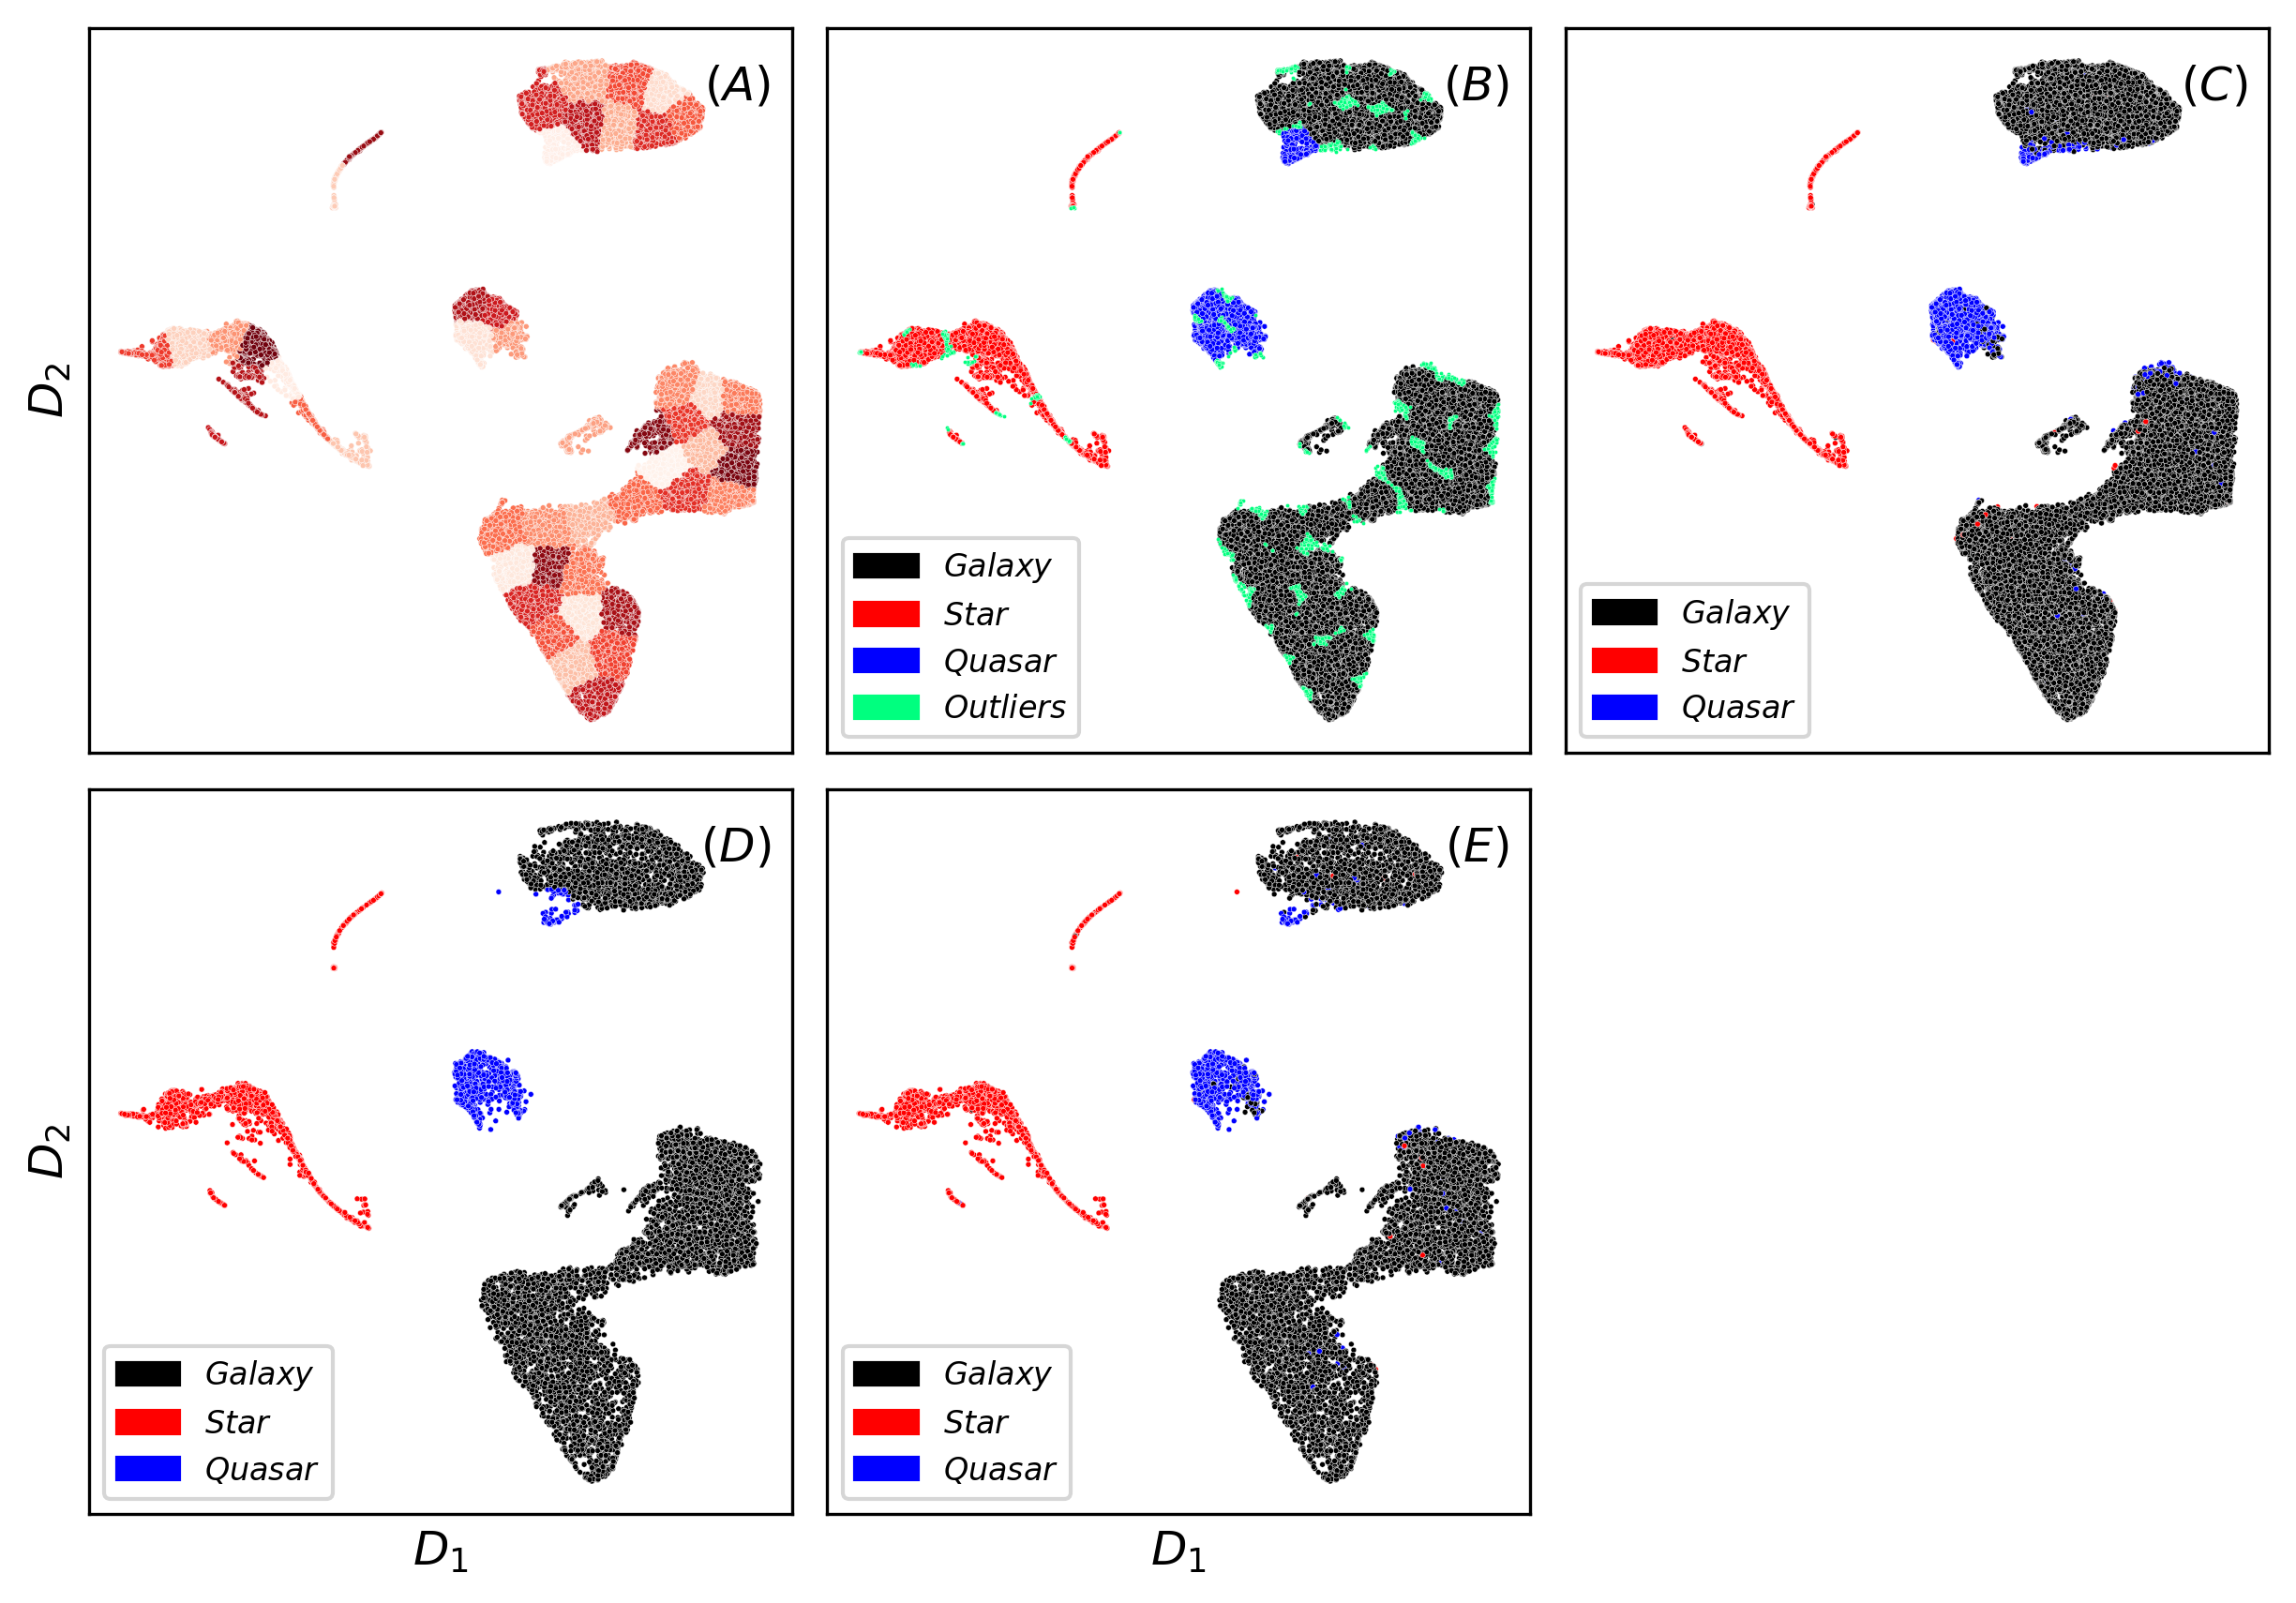

In [31]:
# Create subplots (still 2x3 but we won't use the last one)
fig, axes = plt.subplots(2, 3, dpi=300, figsize=(10, 7))  # Adjusted width
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Set color palette
palette = sns.color_palette('Reds', n_colors=50)

# --- Plot 1 ---
sns.scatterplot(x=N_df.iloc[:, 0], y=N_df.iloc[:, 1], hue=N_df['km_label'], s=2, palette=palette, legend=None, ax=axes[0, 0])
axes[0, 0].set_xlabel('', fontsize=12)
axes[0, 0].set_ylabel('$D_{2}$', fontsize=12)
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

# --- Plot 2 ---
sns.scatterplot(x=D1.iloc[:, 1], y=D1.iloc[:, 2], hue=D1['class'], s=2, palette=['red', 'k', 'blue'], 
                legend=True, ax=axes[0, 1])
sns.scatterplot(x=D2.iloc[:, 1], y=D2.iloc[:, 2], c='#00ff7f', s=1, legend=True, ax=axes[0, 1])
axes[0, 1].set_xlabel('', fontsize=12)
axes[0, 1].set_ylabel('', fontsize=12)
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
palette = ['red', 'k', 'blue', '#00ff7f']
red_patch = mpatches.Patch(color=palette[1], label='$Galaxy$')
brown_patch = mpatches.Patch(color=palette[0], label='$Star$')
orange_patch = mpatches.Patch(color=palette[2], label='$Quasar$')
blue_patch = mpatches.Patch(color=palette[3], label='$Outliers$')
axes[0, 1].legend(handles=[red_patch, brown_patch, orange_patch, blue_patch], loc='lower left', fontsize=8)

# --- Plot 3 ---
sns.scatterplot(x=umap_df_train[:, 0], y=umap_df_train[:, 1], hue=df_train['Hclass'], s=2, palette=['red', 'k', 'blue'], 
                legend=True, ax=axes[0, 2])
axes[0, 2].set_xlabel('', fontsize=12)
axes[0, 2].set_ylabel('', fontsize=12)
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])
palette = ['red', 'k', 'blue']
red_patch = mpatches.Patch(color=palette[1], label='$Galaxy$')
brown_patch = mpatches.Patch(color=palette[0], label='$Star$')
orange_patch = mpatches.Patch(color=palette[2], label='$Quasar$')
axes[0, 2].legend(handles=[red_patch, brown_patch, orange_patch], loc='lower left', fontsize=8)

# --- Plot 4 ---
sns.scatterplot(x=umap_df_test[:,0], y=umap_df_test[:,1], hue=y_new, palette=['red', 'k', 'blue'],
                s=2, legend=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('$D_{1}$', fontsize=12)
axes[1, 0].set_ylabel('$D_{2}$', fontsize=12)
palette = ['red', 'k', 'blue']
red_patch = mpatches.Patch(color=palette[1], label='$Galaxy$')
blue_patch = mpatches.Patch(color=palette[0], label='$Star$')
brown_patch = mpatches.Patch(color=palette[2], label='$Quasar$')
axes[1, 0].legend(handles=[red_patch, blue_patch, brown_patch], loc='lower left', fontsize=8)
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

# --- Plot 5 ---
sns.scatterplot(x=umap_df_test[:,0], y=umap_df_test[:,1], hue=df_test['Hclass'], palette=['red', 'k', 'blue'],
                s=2, legend=True, ax=axes[1, 1])
axes[1, 1].set_xlabel('$D_{1}$', fontsize=12)
axes[1, 1].set_ylabel('', fontsize=12)
palette = ['red', 'k', 'blue']
red_patch = mpatches.Patch(color=palette[1], label='$Galaxy$')
blue_patch = mpatches.Patch(color=palette[0], label='$Star$')
brown_patch = mpatches.Patch(color=palette[2], label='$Quasar$')
axes[1, 1].legend(handles=[red_patch, blue_patch, brown_patch], loc='lower left', fontsize=8)
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])

# --- Remove the sixth subplot (axes[1, 2]) ---
fig.delaxes(axes[1, 2])  # This removes the empty subplot

# Add labels to subplots (now only A-E)
axes[0, 0].text(0.97, 0.95, '($A$)', transform=axes[0, 0].transAxes, horizontalalignment='right', verticalalignment='top', fontsize=12)
axes[0, 1].text(0.97, 0.95, '($B$)', transform=axes[0, 1].transAxes, horizontalalignment='right', verticalalignment='top', fontsize=12)
axes[0, 2].text(0.97, 0.95, '($C$)', transform=axes[0, 2].transAxes, horizontalalignment='right', verticalalignment='top', fontsize=12)
axes[1, 0].text(0.97, 0.95, '($D$)', transform=axes[1, 0].transAxes, horizontalalignment='right', verticalalignment='top', fontsize=12)
axes[1, 1].text(0.97, 0.95, '($E$)', transform=axes[1, 1].transAxes, horizontalalignment='right', verticalalignment='top', fontsize=12);